# Case 1. Categorical simulation with pyramids

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import ot

from mpstool import connectivity, stats
from geone import img, imgplot, deesseinterface

from utils import compute

In [25]:
%load_ext autoreload
%autoreload 1
%aimport ensemble, simulator, scoring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training image

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f840d15b5e0>)

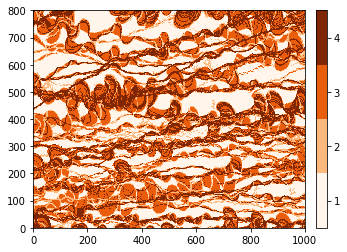

In [28]:
ti = img.readImageGslib('data/ti_4cat_wl375_2.gslib')
ti.sx = 1
ti.sy = 1
imgplot.drawImage2D(ti, categ=True, cmap=plt.cm.get_cmap('Oranges', 4))

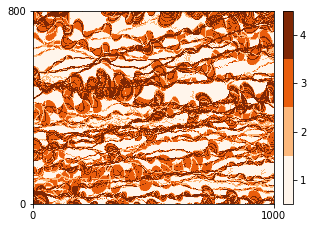

In [31]:
plt.figure(figsize=(2*3.54330709,3.54330709))
imgplot.drawImage2D(ti,
                categ=True,
                cmap=plt.cm.get_cmap('Oranges', 4),
                #cticks=[2126, 2969],
                #cticklabels=['2126 m', '2969 m'],
                #vmin=2126,
                #vmax=2969,
                #cticklabels_fontsize=14,
                #xticklabels_fontsize=14,
                #yticklabels_fontsize=14,
                xticks=[0,ti.nx],
                yticks=[0,ti.ny],
                #title='TI',
                #title_fontsize=14,
               )
plt.savefig(f'figures/fluvial-ti.pdf', dpi=300)

## Reference ensemble

In [4]:
ref_ensemble = ensemble.Ensemble.from_ti(ti=ti,
                                         x_size=200,
                                         y_size=200,
                                         size=400,
                                         seed=123)

In [5]:
def categorical_plot(fig, ax, image):
    mpb = ax.imshow(image, cmap=plt.cm.get_cmap('Oranges', 4), origin='lower', vmin=0.5, vmax=4.5)
    ax.set_xticks([0, 200])
    ax.set_yticks([0, 200])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size='5%', pad='5%')    
    fig.colorbar(mpb, cax=cax, ax=ax, ticks=[1,2,3,4])
    return mpb
    

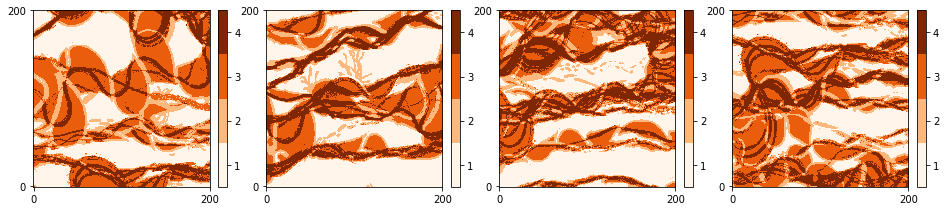

In [6]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
for i, ax in enumerate(axes):
    categorical_plot(fig, ax, ref_ensemble[i])

## DS ensembles and parameters

In [7]:
def load_ensembles(row, simulator_class):
    simulator_obj = simulator_class(nneighboringNode=row['nneighboringNode'],
                 distanceThreshold=row['distanceThreshold'],
                 maxScanFraction=row['maxScanFraction'],
                 root_dir='ds')
    
    ensemble, timing = simulator_obj.get_ensemble(ti,
                                                  ensemble_size=40,
                                                  nthreads=40,
                                                  seed=444,
                                                  overwrite=True)
    row['timing'] = timing
    for function in (connectivity.get_function, stats.variogram):
        f = lambda x: function(x, axis=1)
        row[f'ot_{function.__name__}'] = scoring.avg_wasserstein(ref_ensemble, ensemble, f)
    
    return row

In [8]:
def compute_scores(df, simulator_class):
    return df.apply(lambda row: load_ensembles(row, simulator_class), axis=1)

In [9]:
parameter_sets = [ [n, i/n] for n in [8, 16, 32, 64]
                  for i in range(1, n//4 +1)]

df_ds_parameters = pd.DataFrame(parameter_sets,
                                columns = ['nneighboringNode',
                                           'distanceThreshold'])
df_ds_parameters['maxScanFraction'] = 0.25
df_ds_parameters.head()
len(df_ds_parameters)

30

In [10]:
df_ds = compute('df_ds.pickle', compute_scores, df_ds_parameters, simulator.FluvialDS)
df_ds

,nneighboringNode,distanceThreshold,maxScanFraction,timing,ot_get_function,ot_variogram
0,8.0,0.125000,0.25,129.887071,0.084340,0.061102
1,8.0,0.250000,0.25,88.621959,0.088630,0.068937
2,16.0,0.062500,0.25,410.775545,0.044923,0.014085
3,16.0,0.125000,0.25,269.496509,0.072816,0.050752
4,16.0,0.187500,0.25,125.249846,0.089359,0.093465
5,16.0,0.250000,0.25,97.791824,0.103643,0.102236
6,32.0,0.031250,0.25,836.008235,0.042915,0.012964
7,32.0,0.062500,0.25,691.804296,0.043176,0.009166
8,32.0,0.093750,0.25,640.652173,0.054629,0.015020
9,32.0,0.125000,0.25,548.797120,0.059010,0.037186


In [11]:
for row in df_dsbc.sort_values(by='total_error').iterrows():
    print(row['timing'])

NameError: name 'df_dsbc' is not defined

## DSBC ensembles

In [12]:
f_values = [1/i for i in [8, 16, 32, 64, 128, 256]]
n_values = [8, 16, 24, 32, 64]
parameter_sets = [[i,j] for i in n_values for j in f_values] 

df_dsbc_parameters = pd.DataFrame(parameter_sets, columns=['nneighboringNode', 'maxScanFraction'])
df_dsbc_parameters['distanceThreshold'] = 0
df_dsbc_parameters.head()
len(df_dsbc_parameters)

30

In [13]:
df_dsbc = compute('df_dsbc_ext2.pickle', compute_scores, df_dsbc_parameters, simulator.FluvialDSBC)
df_dsbc.head()

,nneighboringNode,maxScanFraction,distanceThreshold,timing,ot_get_function,ot_variogram
0,8.0,0.125000,0.0,596.812558,0.066564,0.025808
1,8.0,0.062500,0.0,354.630691,0.070182,0.026933
2,8.0,0.031250,0.0,194.485949,0.096688,0.055310
3,8.0,0.015625,0.0,119.426028,0.108827,0.074050
4,8.0,0.007812,0.0,175.668396,0.108582,0.078138


In [14]:
max_conn = max(df_ds['ot_get_function'].max(), df_dsbc['ot_get_function'].max())
max_vario = max(df_ds['ot_variogram'].max(), df_dsbc['ot_variogram'].max())
df_ds['error_connectivity'] = df_ds['ot_get_function']/max_conn
df_ds['error_variogram'] = df_ds['ot_variogram']/max_vario
df_ds['total_error'] = df_ds['error_connectivity'] + df_ds['error_variogram']

In [15]:
df_dsbc['error_connectivity'] = df_dsbc['ot_get_function']/max_conn
df_dsbc['error_variogram'] = df_dsbc['ot_variogram']/max_vario
df_dsbc['total_error'] = df_dsbc['error_connectivity'] + df_dsbc['error_variogram']

In [51]:
df_a = pd.concat((df_ds.sort_values(by='total_error').head(),
                            df_dsbc.sort_values(by='total_error').head()))
df_a

,nneighboringNode,distanceThreshold,maxScanFraction,timing,ot_get_function,ot_variogram,error_connectivity,error_variogram,total_error
15,64.0,0.031250,0.2500,1604.382576,0.031950,0.011938,0.185648,0.093767,0.279414
16,64.0,0.046875,0.2500,1504.232641,0.033343,0.011670,0.193743,0.091669,0.285412
14,64.0,0.015625,0.2500,1727.223604,0.036359,0.009862,0.211267,0.077467,0.288734
17,64.0,0.062500,0.2500,1336.999503,0.043332,0.008789,0.251784,0.069034,0.320819
7,32.0,0.062500,0.2500,691.804296,0.043176,0.009166,0.250879,0.071995,0.322874
18,32.0,0.000000,0.1250,1067.108648,0.034466,0.018648,0.200268,0.146478,0.346746
25,64.0,0.000000,0.0625,1202.601410,0.041393,0.019919,0.240522,0.156456,0.396978
24,64.0,0.000000,0.1250,1760.166218,0.046674,0.017716,0.271203,0.139151,0.410354
12,24.0,0.000000,0.1250,932.467085,0.045751,0.019457,0.265840,0.152829,0.418669
6,16.0,0.000000,0.1250,736.138966,0.044298,0.021073,0.257398,0.165520,0.422918


In [59]:
df_a['timing'] = df_a['timing']/40
for col in ['nneighboringNode', 'timing']:
    df_a[col] = df_a[col].map(lambda x: int(x))
for col in ['ot_get_function', 'ot_variogram', 'error_connectivity', 'error_variogram', 'total_error']:
    df_a[col] = df_a[col].map(lambda x: np.round(x, 3))
df_a.to_latex("figures/fluvial-table.tex", index=False)

In [62]:
1/0.031250, 1/ 0.046875, 1/0.015625, 1/0.062500, 1/0.125

(32.0, 21.333333333333332, 64.0, 16.0, 8.0)

In [61]:
64/3

21.333333333333332

## Analysis

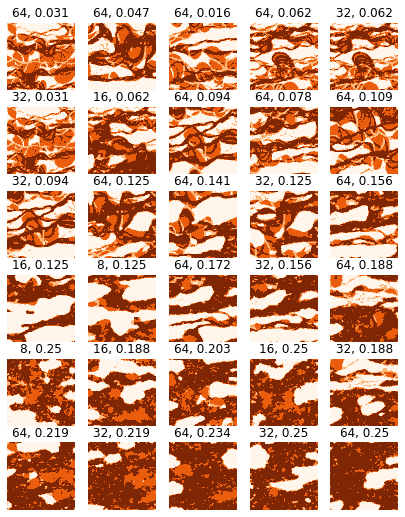

In [32]:
import pickle
fig, axs = plt.subplots(6,5, figsize=(7,9))
for ax, (index, row) in zip(axs.flatten(), df_ds.sort_values(by='total_error').iterrows()):
    with open(f"ds/ds-{row['nneighboringNode']}-{row['distanceThreshold']}-{row['maxScanFraction']}/member-0.pickle", 'rb') as fh:
        member = pickle.load(fh)
    ax.imshow(member,cmap=plt.cm.get_cmap('Oranges', 4), origin='lower')
    ax.set_title(f"{int(row['nneighboringNode'])}, {np.round(row['distanceThreshold'],3)}")
    ax.axis('off')
fig.savefig(f'figures/fluvial-ds.pdf', dpi=300)

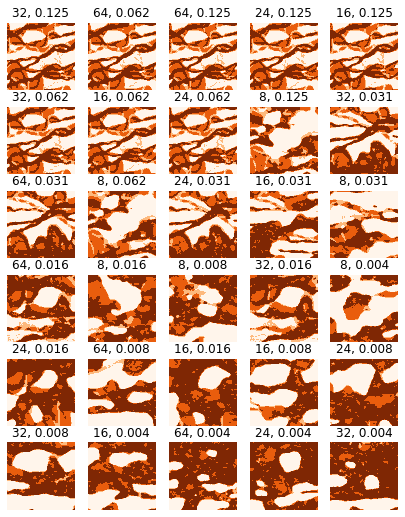

In [33]:
import pickle
fig, axs = plt.subplots(6,5, figsize=(7,9))
for ax, (index, row) in zip(axs.flatten(), df_dsbc.sort_values(by='total_error').iterrows()):
    with open(f"ds/dsbc-{row['nneighboringNode']}-{row['maxScanFraction']}/member-0.pickle", 'rb') as fh:
        member = pickle.load(fh)
    ax.imshow(member,cmap=plt.cm.get_cmap('Oranges', 4), origin='lower')
    ax.set_title(f"{int(row['nneighboringNode'])}, {np.round(row['maxScanFraction'],3)}")
    ax.axis('off')
fig.savefig(f'figures/fluvial-dsbc.pdf', dpi=300)

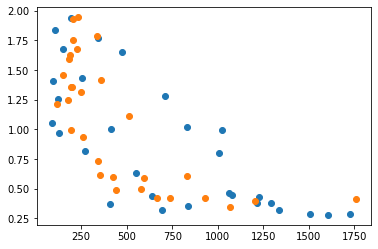

In [16]:
plt.scatter(x=df_ds['timing'], y=df_ds['total_error'])
plt.scatter(x=df_dsbc['timing'], y=df_dsbc['total_error'])

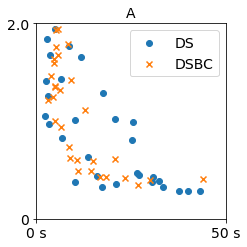

In [64]:
fig, ax = plt.subplots(figsize=(3.54330709,3.54330709))
ax.scatter(x=df_ds['timing']/40, y=df_ds['total_error'])
ax.scatter(x=df_dsbc['timing']/40, y=df_dsbc['total_error'], marker='x')
ax.set(xlim=[0,50], ylim=[0, 2.0])
ax.set_xticks([0,50])
ax.set_yticks([0, 2.0])
ax.set_xticklabels(['0 s','50 s'], fontsize=14)
ax.set_yticklabels(['0','2.0'], fontsize=14)
ax.legend(['DS', 'DSBC'], fontsize=14)
ax.set_title('A', fontsize=14)
fig.tight_layout()
fig.savefig(f'figures/fluvial-scatter.pdf', dpi=300)

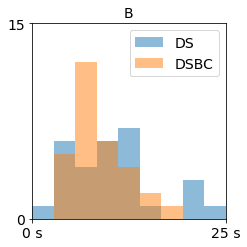

In [65]:
fig, ax = plt.subplots(figsize=(3.54330709,3.54330709))
ax.hist(df_ds['total_error']*df_ds['timing']/40, bins=np.linspace(0,25,10), alpha=0.5)
ax.hist(df_dsbc['total_error']*df_dsbc['timing']/40, bins=np.linspace(0,25,10), alpha=0.5)
ax.set(xlim=[0,25], ylim=[0, 15])
ax.set_xticks([0,25])
ax.set_yticks([0, 15])
ax.set_xticklabels(['0 s','25 s'], fontsize=14)
ax.set_yticklabels(['0','15'], fontsize=14)
ax.legend(['DS', 'DSBC'], fontsize=14)
ax.set_title('B', fontsize=14)
fig.tight_layout()
fig.savefig(f'figures/fluvial-histogram.pdf', dpi=300)

(array([6., 9., 7., 2., 3., 2., 1.]),
 array([144.98255247, 227.45524973, 309.92794699, 392.40064425,
        474.8733415 , 557.34603876, 639.81873602, 722.29143327]),
 <BarContainer object of 7 artists>)

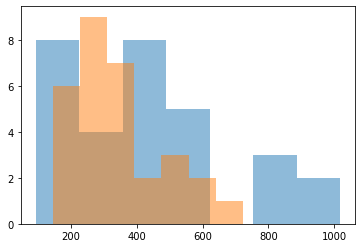

(array([2., 7., 7., 4., 3., 2., 2., 2., 0., 1.]),
 array([144.98255247, 202.71344055, 260.44432863, 318.17521671,
        375.90610479, 433.63699287, 491.36788095, 549.09876903,
        606.82965711, 664.56054519, 722.29143327]),
 <BarContainer object of 10 artists>)

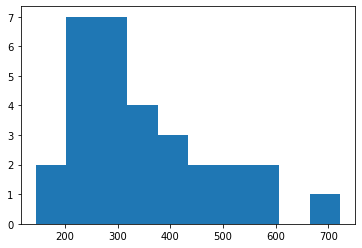

In [19]:
plt.hist(np.sort((df_dsbc['error_variogram']+df_dsbc['error_connectivity'])*df_dsbc['timing']))